# Class 10: Optimization and Pyomo

&#169; University of Notre Dame. CBE 20258. Spring 2020.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: You are expected to read this entire notebook before class.
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Fill in the missing constraint.
</div>

In [2]:
# Create instance of concrete Pyomo model.
# concrete means all of the sets and model data are specified at the time of model construction.
# In this class, you'll use a concrete model.
m = ConcreteModel()

## Declare variables with initial values with bounds
m.x1 = Var(initialize=1, bounds=(-10, 10))
m.x2 = Var(initialize=1, bounds=(-10, 10))
m.x3 = Var(initialize=1, bounds=(-10, 10))

## Declare objective
m.OBJ = Objective(expr=m.x1**2 + 2*m.x2**2 - m.x3, sense = minimize)

## Declare equality constraints
m.h1 = Constraint(expr= m.x1 + m.x2 == 1)

### BEGIN SOLUTION
m.h2 = Constraint(expr= m.x1 + 2*m.x2 - m.x3 == 5)
### END SOLUTION

## Display model
m.pprint()

3 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
    x3 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals

1 Objective Declarations
    OBJ : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : x1**2 + 2*x2**2 - x3

2 Constraint Declarations
    h1 : Size=1, Index=None, Active=True
        Key  : Lower : Body    : Upper : Active
        None :   1.0 : x1 + x2 :   1.0 :   True
    h2 : Size=1, Index=None, Active=True
        Key  : Lower : Body           : Upper : Active
        None :   5.0 : x1 + 2*x2 - x3 :   5.0 :   True

6 Declarations: x1 x2 x3 OBJ h1 h2


We see a lot of information printed on the screen. For example, we see:

```
3 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :   -10 :     1 :    10 : False : False :  Reals
```

This shows the lower bound, initial value, and upper bound for the variable named `x1`.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Run the code below.
</div>

In [3]:
## Specify IPOPT as solver
solver = SolverFactory('ipopt')

## Solve the model
results = solver.solve(m, tee = True)

Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        5
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total

Now let's inspect the solution. We'll use the function `value()` to extract the numeric value from the Pyomo variable object.

In [4]:
## Return the solution
print("x1 = ",value(m.x1))
print("x2 = ",value(m.x2))
print("x3 = ",value(m.x3))
print("\n")

x1 =  0.49999999996668265
x2 =  0.5000000000333173
x3 =  -3.4999999999666827




<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: First write the constraints as a linear system of equations. Then complete the function below to solve the following constraints. We will treat $x_1$ and $x_2$ as the unknown variables. We will treat $x_3$ as a known constant (parameter).</div>

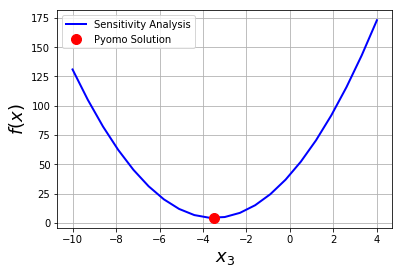

In [5]:
def constraints(x3):
    ''' Solve the linear constraints
    
    Args:
        x3: Value for the decision variable x3
        
    Returns:
        x1 and x2: Values calculated from the constraints
    '''

    ### BEGIN HIDDEN SOLUTION
    A = np.array([[1, 1],[1, 2]])
    b = np.array([1, 5+x3])
    ### END HIDDEN SOLUTION

    z = np.linalg.solve(A,b)
    x1 = z[0]
    x2 = z[1]
    return x1, x2

# Define a lambda function to plot the objective
objective = lambda x1, x2, x3: x1**2 + 2*x2**2 - x3

# Guess many values of x3.
x3_guesses = np.linspace(-10,4,21)
obj = []
for x3 in x3_guesses:
    # Solve the constraints to determine x1 and x2
    x1, x2 = constraints(x3)
    # Calculate the store the objective function value
    obj.append(objective(x1,x2,x3))

# Plot the objective function value versus x3
plt.plot(x3_guesses, obj,color='blue',linewidth=2,label="Sensitivity Analysis")
plt.xlabel("$x_3$",fontsize=18)
plt.ylabel("$f(x)$",fontsize=18)
x3_sln = value(m.x3)
obj_sln = value(m.OBJ)
plt.plot(x3_sln, obj_sln,marker='o',color='red',markersize=10,label="Pyomo Solution",linestyle='')
plt.legend()
plt.grid(True)
plt.show()

Suppose we have \\$20,000 to invest in planting cherry trees.  We can plant a mix of sour (dessert) cherries and sweet cherries (the ones you like to eat).  The sour cherry trees cost \\$20 each, and the sweet cherry trees cost \\$10 each.  The sweet cherries, however, can be sold for \\$100 per tree per year when mature if fully pollinated, while the sour cherries can be sold for only \\$25 per tree when mature.  Finally, the yield per tree of the sweet cherry trees depends on their proximity to the sour cherry trees, since they are not self-pollinating.  If the number of sour trees is given by $x_1$ and the number of sweet trees is $x_2$, we shall take the yield (the fraction of the fully pollinated yield) of the sweet trees to be $x_1$ / ($x_2$ + $x_1$).

### 10d-i. Step 1: Develop Mathematical Model, Convert to Canonical Form

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Write the optimization problem in canonical form. Turn in on paper as you leave class.
</div>

### 10d-ii. Step 2: Solve in Python

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Finish the Pyomo model below.
</div>

In [6]:
## Problem Specifications

# Concrete model
m = ConcreteModel()

# Budget
b = 20000;

# Cost per sour tree
c1 = 20;

# Cost per sweet tree
c2 = 10;

# Revenue per fully polinated sour tree
p1 = 25;

# Revenue per fully polinated sweet tree
p2 = 100

## Define variables
m.x1 = Var(initialize=1, bounds=(0,None)) # sour cherries
### BEGIN SOLUTION
m.x2 = Var(initialize=1, bounds=(0,None)) # sweet cherries
### END SOLUTION

## Objective function
### BEGIN SOLUTION
m.obj = Objective(expr=p1*m.x1 + p2*m.x2*m.x1/(m.x1 + m.x2), sense = maximize)
### END SOLUTION

## Constraint
### BEGIN SOLUTION
m.con = Constraint(expr=b - c1*m.x1 - c2*m.x2 >= 0)
### END SOLUTION

## Print the model
m.pprint()

2 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :     1 :  None : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :     1 :  None : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 25*x1 + 100*x2*x1*(1/(x1 + x2))

1 Constraint Declarations
    con : Size=1, Index=None, Active=True
        Key  : Lower : Body                  : Upper : Active
        None :   0.0 : 20000 - 20*x1 - 10*x2 :  +Inf :   True

4 Declarations: x1 x2 obj con


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Solve the Pyomo model.
</div>

In [7]:
## Solve the model
# Recall, we already defined solver
results = solver.solve(m, tee = True)

Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total

In [8]:
# Print the solution
print("Plant ",value(m.x1),"sour cherry trees")
print("Plant ",value(m.x2),"sweet cherry trees")
print("Giving revenue of",value(m.obj),"dollars")

Plant  666.6666733332888 sour cherry trees
Plant  666.6666733333219 sweet cherry trees
Giving revenue of 50000.00049999749 dollars


### 10d-iii. Interpret Answer

Can we plant 2/3 of a cherry tree?

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Determine the best way to round the solution.
</div>

In [9]:
## Let's plant 667 sour trees and resolve
m.x1.fix(667)
results = solver.solve(m, tee = False)
print("Plant ",value(m.x1),"sour cherry trees")
print("Plant ",value(m.x2),"sweet cherry trees")
print("Giving revenue of",value(m.obj),"dollars")

Plant  667 sour cherry trees
Plant  666.0000066598999 sweet cherry trees
Giving revenue of 49999.981412058725 dollars


In [10]:
## What if we instead plant 666 sour trees?
m.x1.fix(666)
results = solver.solve(m, tee = False)
print("Plant ",value(m.x1),"sour cherry trees")
print("Plant ",value(m.x2),"sweet cherry trees")
print("Giving revenue of",value(m.obj),"dollars")

Plant  666 sour cherry trees
Plant  668.0000066798995 sweet cherry trees
Giving revenue of 49999.92520397838 dollars


Grid-scale battery energy storage systems (BESS) are expected to play a critical role in supporting wide-spread adoption of renewable electricity. In an effort to *future proof* their electric grid, California has mandated over **1 GW** of BESS power capacity be brought online by 2020. For context, the peak electricity demand in California during 2016 was 46.2 GW: https://www.caiso.com/Documents/CaliforniaISOPeakLoadHistory.pdf}

For policy-makers, technology developers, and investors, there is a critical need to understand the true value of energy storage systems. In California and many regions throughout the United States, electricity is purchased and sold in a wholesale market with time-varying prices (units of \$ / MWh). In principle, a smart battery operator wants to **buy low** (charge) and **sell high** (discharge). This is known as energy arbitrage. 

### 10e-i. Visualize Price Data

The text file `Prices_DAM_ALTA2G_7_B1.csv` contains an entire year of wholesale energy prices for Chino, CA. Let's import and inspect the data using Pandas. Our text file contains only one column and no header. We will manually specify "Price" as the name for the single column.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Run the code below.
</div>

In [11]:
data = pd.read_csv('Prices_DAM_ALTA2G_7_B1.csv',names=['Price'])
data.head()

,Price
0,36.757
1,34.924
2,33.389
3,32.035
4,33.694


Let's compute some summary statistics.

In [12]:
data.describe()

,Price
count,8760.000000
mean,32.516994
std,9.723477
min,-2.128700
25%,26.510000
50%,30.797500
75%,37.544750
max,116.340000


Let's make a histogram.

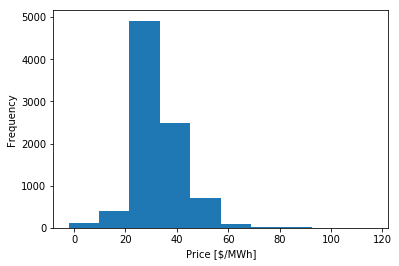

In [13]:
plt.hist(data['Price'])
plt.xlabel("Price [$/MWh]")
plt.ylabel("Frequency")
plt.show()

Finally, let's plot the prices for the first three days in the data set.

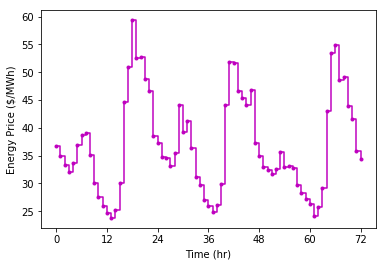

In [14]:
# determine number of hours to plot
nT = 3*24

# determine hour we should start counting
# 0 means start counting at the first hour, i.e., midnight on January 1, 2015
t = 0 + np.arange(nT+1)
price_data = data["Price"][t]

# Make plot.
plt.figure()
plt.step(t,price_data,'m.-',where='post')
plt.xlabel('Time (hr)')
plt.ylabel('Energy Price ($/MWh)')
plt.xticks(range(0,nT+1,12))
plt.show()

### 10e-ii. Create Mathematical Model

For simplicity, assume a battery energy storage system is *price-taker*, i.e., they are subject to the market price but their actions do not influence the market price. During each hour $t$, the battery operator decided to either charge (buy energy) or discharge (sell energy) at rates $c_t$ and $d_t$ (units: MW), respectively, subject to the market price $p_t$ (units: \$/MWh). Assume the battery has a round trip efficiency of $\eta = 88\%$. Let $E_t$ represent the state-of-charge at time $t$ (units: MW).

![battery](battery.png)

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Using the picture above, sketch the battery system. Label $d_t$, $c_t$, $E_t$, and $p_t$ on your sketch. Verify the units are consistent.
</div>

We can now write a constrained optimization problem to compute the optimal market participation strategy (when to buy and sell).

\begin{align*}
    \max_{E,d,c} \quad & \psi := \sum_{t = 1}^{N} p_{t} (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}}, ~~ \forall ~ t \in \{1,...,N\} \\
    & 0 \leq c_{t} \leq c_{max}, ~~ 0 \leq d_{t} \leq d_{max}, \nonumber \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \{1,...,N\}
\end{align*}

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss the optimization problem above with a partner. Then, write a few sentences to explain each equation.
</div>

### 10e-iii. Define Pyomo Model

We can now write the optimization problem in Pyomo. We will create a set `TIME` to write the model compactly.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Finish the Pyomo model below.
</div>

In [15]:
# define a function to build model
def build_model(price,e0 = 0):
    '''
    Create optimization model for battery operation

    Inputs:
        price: Pandas DataFrame with energy price timeseries
        e0: initial value for energy storage level
    
    Output:
        model: Pyomo optimization model
    '''
    
    # Create a concrete Pyomo model. We'll learn more about this in a few weeks
    model = ConcreteModel()

    ## Define Sets

    # Number of timesteps in planning horizon
    model.TIME = Set(initialize = price.index)

    ## Define Parameters

    # Square root of round trip efficiency
    model.sqrteta = Param(initialize = sqrt(0.88))

    # Energy in battery at t=0
    model.E0 = Param(initialize = e0, mutable=True)

    # Charging rate [MW]
    model.c = Var(model.TIME, initialize = 0.0, bounds=(0, 1))

    ### BEGIN SOLUTION
    # Discharging rate [MW]
    model.d = Var(model.TIME, initialize = 0.0, bounds=(0, 1))

    # Energy (state-of-charge) [MWh]
    model.E = Var(model.TIME, initialize = 0.0, bounds=(0, 4))
    ### END SOLUTION
    
    ## Define constraints
    
    # Define Energy Balance constraints. [MWh] = [MW]*[1 hr]
    # Note: this model assumes 1-hour timestep in price data and control actions.
    def EnergyBalance(model,t):
        # First timestep
        if t == 0 :
            return model.E[t] == model.E0 + model.c[t]*model.sqrteta-model.d[t]/model.sqrteta 
        
        # Subsequent timesteps
        else :
            ### BEGIN SOLUTION
            return model.E[t] == model.E[t-1]+model.c[t]*model.sqrteta-model.d[t]/model.sqrteta
            ### END SOLUTION
    
    model.EnergyBalance_Con = Constraint(model.TIME, rule = EnergyBalance)
    
    ## Define the objective function (profit)
    # Receding horizon
    def objfun(model):
        return  sum((-model.c[t] + model.d[t]) * price[t] for t in model.TIME)
    model.OBJ = Objective(rule = objfun, sense = maximize)
    
    return model

### 10e-iv. Solve Optimization Model

We can now create an instance of our Pyomo model. Notice the function `build_model` requires we pass in a Pandas DataFrame with the price data. Let's try the first day only.

In [16]:
# Build the model
instance = build_model(data["Price"][0:24],0.0)

# Specify the solver
solver = SolverFactory('ipopt')

# Solve the model
results = solver.solve(instance, tee = True)

Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       95
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       72
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       72
                     variables with only upper bounds:        0
Total

### 10e-v. Extract Solution from Pyomo

Excellent. Ipopt terminated with the message `Optimal Solution Found`. Let's inspect the answer.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Run the code below.
</div>

In [17]:
# Declare empty lists
c_control = []
d_control = []
E_control = []
time = []

# Loop over elements of TIME set.
for i in instance.TIME:    
    # Record the time
    time.append(value(i))
    
    # Use value( ) function to extract the solution for each varliable and append to the results lists
    c_control.append(value(instance.c[i]))
    
    # Adding negative sign to discharge for plotting
    d_control.append(-value(instance.d[i]))
    E_control.append(value(instance.E[i]))

### 10e-vi. Plot Results

Now let's plot the optimal charge and discharge profile.

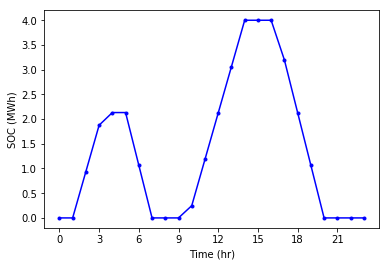

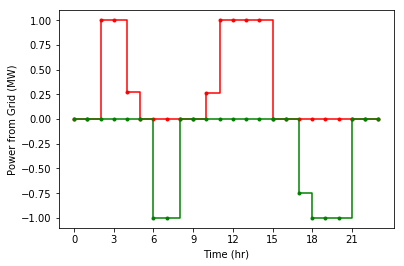

In [18]:
# Plot the state of charge (E)
plt.figure()
plt.plot(time,E_control,'b.-')
plt.xlabel('Time (hr)')
plt.ylabel('SOC (MWh)')
plt.xticks(range(0,24,3))
plt.show()

# Plot the charging and discharging rates
plt.figure()
plt.step(time,c_control,'r.-',where="post")
plt.step(time,d_control,'g.-',where="post")
plt.xlabel('Time (hr)')
plt.ylabel('Power from Grid (MW)')
plt.xticks(range(0,24,3))
plt.show()

# At home: switch this to a stair plot as control actions are constant over the hour.

### 10e-vii. How much money can a 4 MWh battery make in a year?

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Copy the code from 10e-iv to the cell below. Then modify to calculate the revenue for an entire year. Record your answer on the handout. Hint: Do NOT modify the function `create_model`.
</div>

In [19]:
### BEGIN SOLUTION
# Build the model
entire_year = build_model(data["Price"][:],0.0)

# Specify the solver
solver = SolverFactory('ipopt')

# Solve the model
entire_year_results = solver.solve(entire_year, tee = True)

print("Revenue in 2015: $",value(entire_year.OBJ))

### END SOLUTION


Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    35039
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    26280
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    26280
                     variables with only upper bounds:        0
Total

## 10f. Flash Example Revisited

Let's revist the flash example. Here is the **mathematical model**:

Feed Specifications: $F = 1.0$ mol/s, $z_1$ = 0.5 mol/mol, $z_2$ = 0.5 mol/mol

Given Equilibrium Data: $K_1$ = 3 mol/mol, $K_2$ = 0.05 mol/mol

Overall Material Balance

$$F = L + V$$

Component Mass Balances

$$V y_1 + L x_1 = F z_1$$

$$V y_2 + L x_2 = F z_2$$

Thermodynamic Equilibrium

$$y_1 = K_1 x_1$$

$$y_2 = K_2 x_2$$

Summation

$$y_1 + y_2 = x_1 + x_2$$

And here is part of the **code** from Class 9:

In [20]:
def my_f(x):
    ''' Nonlinear system of equations in conancial form F(x) = 0
    Copied from Lecture 7.
    
    Arg:
        x: vector of variables
        
    Returns:
        r: residual, F(x)
    
    '''

    # Initialize residuals
    r = np.zeros(6)
    
    # given data
    F = 1.0
    z1 = 0.5
    z2 = 0.5
    K1 = 3
    K2 = 0.05
    
    # copy values from x to more meaningful names
    L = x[0]
    V = x[1]
    x1 = x[2]
    x2 = x[3]
    y1 = x[4]
    y2 = x[5]
    
    # equation 1: overall mass balance
    r[0] = V + L - F
    
    # equations 2 and 3: component mass balances
    r[1] = V*y1 + L*x1 - F*z1
    r[2] = V*y2 + L*x2 - F*z2
    
    # equation 4 and 5: equilibrium
    r[3] = y1 - K1*x1
    r[4] = y2 - K2*x2
    
    # equation 6: summation
    r[5] = (y1 + y2) - (x1 + x2)
    # This is known as the Rachford-Rice formulation for the summation constraint
    
    return r


<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Convert the code above into a Pyomo model and solve the flash calculation.
</div>

In [21]:
## Create a concrete model
m = ConcreteModel()

## Define the objective to be a constant
m.obj = Objective(expr=1)

## Define a set for components
m.COMPS = Set(initialize=[1,2])

## given data
m.F = Param(initialize=1.0)
m.z = Param(m.COMPS, initialize={1:0.5, 2:0.5})

### BEGIN SOLUTION
m.K = Param(m.COMPS, initialize={1:3, 2:0.05})
### END SOLUTION

## Define variables
m.L = Var(initialize=0.5)
m.V = Var(initialize=0.5)
m.x = Var(m.COMPS, bounds=(0, 1.0), initialize={1:0.5, 2:0.5})
### BEGIN SOLUTION
m.y = Var(m.COMPS, bounds=(0, 1.0), initialize={1:0.5, 2:0.5})
### END SOLUTION

### Define equations

# equation 1: overall mass balance
m.overall_mass_balance = Constraint(expr=m.F == m.V + m.L)

# equations 2 and 3: component mass balances
def eq_comp_mass_balance(model, c):
    ''' model: Pyomo model
        c: set for components
    '''
    
    return model.V * model.y[c] + model.L * model.x[c] == model.F * model.z[c]
    
m.component_mass_balance = Constraint(m.COMPS, rule=eq_comp_mass_balance)

# equation 4 and 5: equilibrium
### BEGIN SOLUTION
def eq_equilibrium(model, c):
    ''' model: Pyomo model
        c: set for components
    '''
    
    return model.K[c] * model.x[c] == model.y[c]
    
m.equilibrium = Constraint(m.COMPS, rule=eq_equilibrium)
### END SOLUTION

# equation 6: summation
### BEGIN SOLUTION
m.summation = Constraint(expr = 0 == sum(m.y[c] - m.x[c] for c in m.COMPS))
### END SOLUTION
# This is known as the Rachford-Rice formulation for the summation constraint

## Print model
m.pprint()

1 Set Declarations
    COMPS : Dim=0, Dimen=1, Size=2, Domain=None, Ordered=False, Bounds=(1, 2)
        [1, 2]

3 Param Declarations
    F : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   1.0
    K : Size=2, Index=COMPS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :     3
          2 :  0.05
    z : Size=2, Index=COMPS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   0.5
          2 :   0.5

4 Var Declarations
    L : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   0.5 :  None : False : False :  Reals
    V : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   0.5 :  None : False : False :  Reals
    x : Size=2, Index=COMPS
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   0.5 :   1.0 : False : False :  Reals
          2 :     0 :   0.

In [22]:
## Solve the model

# Specify the solver
solver = SolverFactory('ipopt')

# Solve!
results = solver.solve(m, tee = True)

Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       18
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total

In [23]:
## Examine the solution
print("L = ",value(m.L),"mol/s")
### BEGIN SOLUTION
for c in m.COMPS:
    print("x[",c,"] = ",value(m.x[c])*100,"mole %")
    
print("\nV = ",value(m.L),"mol/s")
for c in m.COMPS:
    print("y[",c,"] = ",value(m.y[c])*100,"mole %")
### END SOLUTION

L =  0.7236842105263158 mol/s
x[ 1 ] =  32.20338983050847 mole %
x[ 2 ] =  67.79661016949153 mole %

V =  0.7236842105263158 mol/s
y[ 1 ] =  96.61016949152541 mole %
y[ 2 ] =  3.389830508474577 mole %
